# EMit - Emotions in Italian
## Emotion and Target detection
### Emanuele Muzio - 0766230
Il presente notebook rappresenta un'illustrazione dello svolgimento dei due task del contest EMit (Emotions in Italian):
- il primo task, o Task A, è mirato alla classificazione dei sentimenti espressi dai messaggi sui social media riguardanti i prodotti RAI
- il secondo task, o Task B, è mirato alla classificazione del target del messaggio, se sul topic o sulla direzione
Entrambi i task sono classificazione multiclasse e multilabel (nel Task A abbiamo 8 emozioni di base, più _Love_, nel Task B il target può essere uno dei due, entrambi o nessuno).

Ai fini della valutazione dei due task, sono stati forniti dei dataset da utilizzare sia per l'addestramento che per i test, comprensivi di annotazioni.

Per i test del modello sono stati forniti nello specifico due dataset: uno con dati presi all'interno del dominio dei messaggi relativi alle trasmissioni RAI, uno con dati presi fuori da questo dominio (detti OOD, Out of Domain).

In [ ]:
!pip install nltk torch torchmetrics transformers emot pandas scikit-learn
env = 'colab'

In [8]:
from google.colab import drive

root = '.'

if env == 'colab':
  drive.mount('/content/drive')
  root = '/content/drive/MyDrive/NLP'
else:
  root = '/content/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import copy, os
import numpy as np
from sklearn.metrics import classification_report as cr, f1_score as f1
import seaborn as sns
import random as rand
import pickle
import matplotlib.image as mpimg

#Import torch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchmetrics.classification import MultilabelAccuracy
from transformers import AutoTokenizer, AutoModel

# Gestione delle emoji
import emot as emot_imp
emot = emot_imp.core.emot()

## Task A: Emotion detection

Per andare a ricercare la massima precisione (sia per quanto riguarda i dati che il modello), verranno effettuate diverse prove:
- dati: verranno effettuati dei test usando sia dei dati preprocessati che i dati originali (dal momento che il blocco BERT-like del nostro modello trae informazioni anche da punteggiatura, stopwords ecc...)
- modello: verranno testati diverse combinazioni di iperparametri usando un approccio randomizzato per trovare il modello migliore (valutato tramite F1 score)

Per il primo task, procediamo in due step, partendo dal preprocessing del testo (rimozione stopwords, hashtag, menzioni, keyword RT, collegamenti ipertestuali) per poi andare alla classificazione.

Per la tokenizzazione del testo è stato scelto un modello multilingua (dal momento che i messaggi riguardano un'emittente italiana) case-sensitive.

Il supporto alle emoji/emoticons è stato aggiunto rilevando quelle presenti nel testo e facendo un resize del modello per poterle gestire.

Il modello BERT-like da HuggingFace utilizzato è il seguente: _bert-base-multilingual-cased_.

In [10]:
data = pd.read_csv(f"{root}/release/emit_2023-v1/emit_train_A.csv")
text_prep = data["text"]
text = data["text"]
emotions = data.drop(["id","text"], axis=1)
emotions_prep = data.drop(["id","text"], axis=1)
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
nltk.download('stopwords')
stopwords_it = stopwords.words('italian')
X_keywords = ['RT', 'FAV']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Funzione che raccoglie i principali 4 controlli che vengono effettuati sul testo, ovvero:
# - presenza di menzioni ad altri utenti
# - presenza di collegamenti esterni
# - presenza di keyword relative a X (RT, FAV, quest'ultima non presente nei nostri dati)
# - presenza di stop-words in lingua italiana dalla lista fornita dal NaturalLanguageToolKit

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        if t.startswith('@') and len(t) > 1 or t.startswith('http') or t in X_keywords or t.lower() in stopwords_it:
            continue
        else:
            new_text.append(t)
    return " ".join(new_text)

# Funzione per l'estrazione degli hashtag dai messaggi

def getHashtags(text):
    hashtags = []
    for t in text.split(" "):
        if t.startswith('#') and len(t) > 1:
            hashtags.append(t)
        else:
            continue
    return hashtags

# Funzione per la rimozione degli hashtag dai messaggi

def removeHashTags(text):
    new_text = []
    for t in text.split(" "):
        if t.startswith('#') and len(t) > 1:
            continue
        else:
            new_text.append(t)
    return " ".join(new_text)

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

### Task A: Preprocessing
Al fine di valutare soltanto le parti più importanti dei messaggi, con un contributo semantico più corposo, sono state prese diverse decisioni:
- Eliminazione delle menzioni degli utenti (nomi utenti già oscurati nel dataset utilizzato)
- Eliminazione delle stopword da NLTK
- Eliminazione delle keyword legate a X (RT per i retweet e FAV per i messaggi preferiti)
- Eliminazione link esterni
- Eliminazione hashtag

Controlliamo innanzitutto l'integrità dei dati di addestramento

In [12]:
data.isna().sum()

id              0
text            0
Anger           0
Anticipation    0
Disgust         0
Fear            0
Joy             0
Love            0
Neutral         0
Sadness         0
Surprise        0
Trust           0
dtype: int64

Non è necessario fare imputazione in quanto non ci sono dati mancanti all'interno del dataset di addestramento.

Controlliamo anche velocemente quali sono le emozioni maggiormente espresse nei messaggi.

Possiamo vedere come i messaggi esprimano emozioni variegate (con un picco nei messaggi di fiducia/incoraggiamento e un minimo nei messaggi che esprimono timore o paura, fatto comprensibile dal momento che la maggior parte dei commenti riguarda trasmissioni in onda).

<BarContainer object of 10 artists>

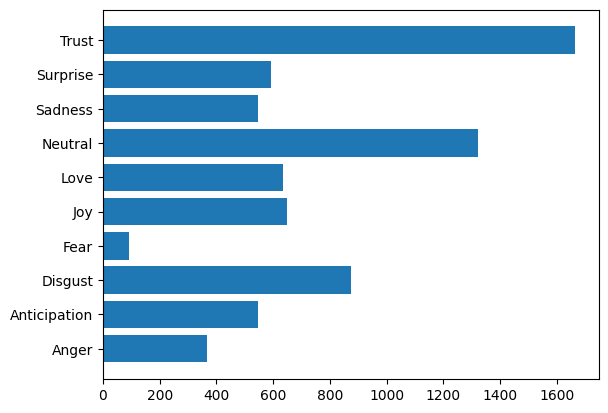

In [13]:
plt.barh(emotions.columns, [emotions[column].sum() for column in emotions.columns])

Possiamo adesso procedere al preprocessing del testo.

In [14]:
text_prep = text_prep.apply(preprocess)

Dopo questo primo passo, è sorto un dubbio riguardante l'utilità degli hashtag e la conseguente decisione sul mantenerli o meno.
La scelta finale è stata quella di rimuoverli, dal momento che gli hashtag più diffusi almeno in questa prima fase non aggiungono molto valore al testo essendo relativi al topic (generalmente il nome del programma televisivo interessato).

Potrebbe essere interessante mantenere queste informazioni per fare uno studio di sentiment analysis differenziata per singolo programma televisivo, tuttavia non è il focus principale del progetto.

Sono stati rilevati in totale 1126 hashtag unici su 5990 totali (in riferimento ai dati di addestramento), con una distribuzione sbilanciata fortemente verso i 20-30 circa più usati, che sono risultati essere hashtag relativi appunto al nome della trasmissione televisiva oggetto del testo.

In [15]:
hashtag_list = list(map(getHashtags, text_prep))
hashtags = []

for h in hashtag_list:
    hashtags.extend(h)

hashtags = list(sorted(hashtags))
unique_hashtags = list(set(hashtags))
hasht_count = [hashtags.count(h) for h in unique_hashtags]

sorted_h = [x for _, x in sorted(zip(hasht_count, unique_hashtags), reverse=True)]
sorted_h_c = list(sorted(hasht_count,reverse=True))

<BarContainer object of 25 artists>

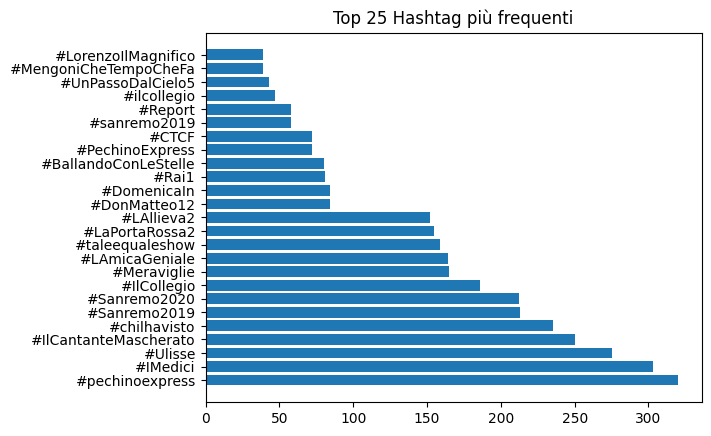

In [16]:
plt.title("Top 25 Hashtag più frequenti")
plt.barh(sorted_h[:25], sorted_h_c[:25])

In [17]:
text_prep = text_prep.apply(removeHashTags)

Alcuni messaggi sono composti soltanto da menzioni
o semplici hashtag, per cui facciamo una veloce pulizia prima di procedere
(al contrario, alcuni messaggi non verrebbero processati dal tokenizer, causando degli errori)

In [18]:
for i in range(len(text_prep)):
    if(len(text_prep[i]) == 0):
        text_prep.drop(i, axis=0, inplace=True)
        emotions_prep.drop(i, axis=0, inplace=True)

Prima di procedere alla classificazione vera e propria, dobbiamo adattare il tokenizer alla presenza delle emoji nel testo, elemento importante per l'interpretazione dei messaggi.

Facciamo quindi una ricerca di emoji ed emoticons presenti e aggiungiamole al tokenizer tramite la funzione add_tokens(), per poi fare un resize del modello e completare questo step.

In [19]:
bulk_emoji = emot.bulk_emoji(text_prep)

unique_emoji = []

for i in range(len(bulk_emoji)):
    res = bulk_emoji[i]
    if res['flag']:
        unique_emoji.extend(res['value'])

unique_emoji = list(set(unique_emoji))

emoji_to_add = set(unique_emoji) - set(tokenizer.vocab.keys())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [20]:
bulk_emoticons = emot.bulk_emoticons(text_prep)

unique_emoticons = []

for i in range(len(bulk_emoticons)):
    res = bulk_emoticons[i]
    if res['flag']:
        unique_emoticons.extend(res['value'])

unique_emoticons = list(set(unique_emoticons))

emoticons_to_add = set(unique_emoticons) - set(tokenizer.vocab.keys())

In [21]:
new_tokens = []
new_tokens.extend(emoji_to_add)
new_tokens.extend(emoticons_to_add)

In [22]:
print(f"Adding: {len(new_tokens)} emoji/emoticons")

Adding: 261 emoji/emoticons


In [23]:
tokenizer.add_tokens(list(new_tokens))
model.resize_token_embeddings(len(tokenizer))

Embedding(119808, 768)

Vediamo adesso di stabilire brevemente una lunghezza massima in parole dei messaggi.

Possiamo vedere come la stragrande maggioranza dei messaggi abbia una lunghezza inferiore a 25-30 parole, per cui useremo 30 come tetto massimo.

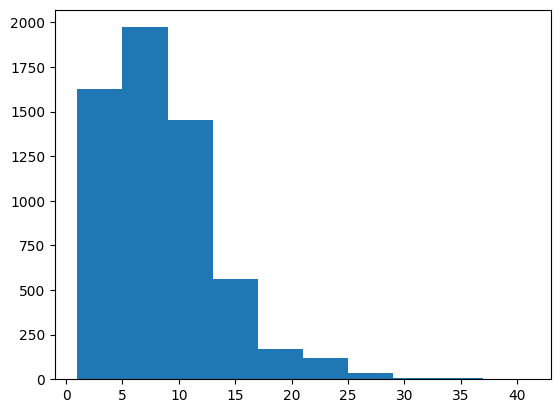

In [24]:
plt.hist([len(t.split(' ')) for t in text_prep])
MAX_LEN = 30

Vediamo come appare il testo dei messaggi dopo questa operazione di pulizia

In [25]:
print(text[5], '\n',text_prep[5])

@user Appunto Maurizio 😁 e i loro marchio di fabbrica 😉 
 Appunto Maurizio 😁 marchio fabbrica 😉


### Task A: Classificazione

Arrivati a questo punto, dobbiamo per prima cosa addestrare il nostro classificatore per il task che dovrà svolgere.

La struttura adottata sarà composta da un BTE (Bidirectional Transformer Encoder) per l'encoding degli embeddings generati dal tokenizer.
A questa base aggiungiamo un layer dense e infine una sigmoide che ci permette di fare la classificazione multi-label richiesta.

Procediamo a passare tutti i dati etichettati al nostro classificatore.

Sfruttiamo, se possibile, l'architettura CUDA.

In [26]:
device = ("cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = ("cuda")

print(f"Using {device} device")

Using cuda device


Definiamo in anticipo la struttura del nostro dataset sfruttando le API di Pytorch: trasformeremo infatti i nostri dataset attraverso un dataloader, classe che ci permette di dividere in batch i nostri dati durante l'addestramento.

In [27]:
# inputs: testi dei messaggi
# labels: target relativo alle reali emozioni espresse dal messaggio, es. [0, 0, 1, 0...]
# tokenizer: il tokenizer a cui abbiamo aggiunto le emoji precedentemente
# MAX_LEN: lunghezza massima oltre il quale il tokenizer effettuerà un truncate sui messaggi

class _Dataset(Dataset):
    def __init__(self, inputs, labels, tokenizer, MAX_LEN, transform=None):
        self.transform = transform
        self.inputs = inputs
        self.labels = [torch.tensor(l) for l in labels]
        self.tokenizer = tokenizer
        self.MAX_LEN = MAX_LEN

    def __len__(self):
        return len(self.inputs)

    # Estraiamo tramite tokenizer gli id dell'input da passare al modello
    # Dobbiamo infatti lavorare con gli embeddings per
    # poter classificare il nostro testo

    def __getitem__(self, idx):
        inputs = tokenizer(self.inputs.iloc[idx], add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = self.MAX_LEN, truncation=True)
        labels = self.labels[idx]
        return {
            'ids': inputs['input_ids'],
            'mask': inputs['attention_mask'],
            'token_type_ids': inputs['token_type_ids'],
            'labels': labels
        }

Andiamo adesso a definire la struttura del nostro classificatore, che possiamo dividere in due macro blocchi:
- blocco BERT-like che gestisce l'input (ovvero i dati testuali tokenizzati)
- blocco di classificazione multi-classe multi-label (principalmente un layer dense e una sigmoide in uscita)

Ci interessa in particolare andare a recuperare l'ultimo strato nascosto del blocco BERT-like in modo da passarlo al classificatore e ottenere le logits.

In [28]:


class BTEClassifier(nn.Module):
    def __init__(self, dropout, num_classes, bte):
        super(BTEClassifier, self).__init__()
        self.bte = bte # Blocco BTE - Bidirectional Transformer Encoder
        self.classifier = nn.Sequential(
            nn.Dropout(dropout), # Layer di dropout,
            nn.Linear(768, num_classes), # Layer dense su cui fare fine tuning
            nn.Sigmoid()
        )

    def forward(self, ids, mask, token_type_ids):
        output = self.bte(ids, attention_mask = mask, token_type_ids = token_type_ids).last_hidden_state
        output = output[:,0,:]
        output = self.classifier(output)
        return output

E' stato scelto di implementare un piccolo meccanismo di early stopping per l'addestramento in modo da velocizzare il processo e non sprecare inutilmente tempo su configurazioni non particolarmente proficue di iperparametri della rete.

E' stato poi impostato con un livello di pazienza molto sensibile e un delta ragionevolmente alto in base ai risultati osservati (ovvero generalmente una minimizzazione della loss lenta) e a causa dei rallentamenti osservati con il procedere dell'addestramento.

In [29]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    # Ad ogni epoca, se non è stato osservato un miglioramento vero e proprio per più di n epoche
    # (dove n = patience dell'early stopper) verrà interrotto l'addestramento di quel modello

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Vediamo adesso il loop di addestramento, dal momento che andremo a fare fine tuning del modello per adattarlo ai nostri dati:
- segnaliamo a pytorch l'inizio dell'addestramento tramite invocazione del metodo _.train()_
- calcoliamo la loss sui risultati ottenuti tramite Binary Cross-Entropy
- aggiornamento del gradiente trmaite funzione _.backward()_
- tramite optimizer (Adam nel nostro caso) faccio un singolo step di ottimizzazione (_.step()_)
- aggiorno la loss e l'accuracy dell'epoca (quest'ultima misurata tramite la MultiLabelAccuracy da Pytorch) e ripeto

In [30]:
def train(model, dataloader, loss, accuracy, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for d in dataloader:
        (ids, mask, token_type_ids, labels_) = d.values()

        optimizer.zero_grad()

        input_ids = ids.squeeze(1).to(device)
        input_mask = mask.squeeze(1).to(device)
        input_token_type_ids = token_type_ids.squeeze(1).to(device)
        labels_ = labels_.squeeze(1).to(device).float()

        output = model(input_ids, input_mask, input_token_type_ids)

        batch_loss = loss(output, labels_)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        epoch_acc += accuracy(output, labels_).item()

        input_ids = input_ids.detach().cpu()
        input_mask = input_mask.detach().cpu()
        input_token_type_ids = input_token_type_ids.detach().cpu()
        labels_ = labels_.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

Passiamo invece alla fase di valiazione:
- informo il modello che siamo in fase di valutazione (_.eval()_) e che non ho necessità di avere informazioni sul gradiente (_.no grad()_)
- aggiorno loss e accuracy del modello come in fase di addestramento, e se durante quest'epoca ho raggiunto l'accuracy massima ottenuta fino ad ora, conservo il risultato e i pesi, effettuando un salvataggio dello stato del modello

In [31]:
def val(model, dataloader, loss, accuracy, device, best_acc, best_weights):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():
        for d in dataloader:
            (ids, mask, token_type_ids, labels_) = d.values()

            input_ids = ids.squeeze(1).to(device)
            input_mask = mask.squeeze(1).to(device)
            input_token_type_ids = token_type_ids.squeeze(1).to(device)
            labels_ = labels_.squeeze(1).to(device).float()

            output = model(input_ids, input_mask, input_token_type_ids)

            batch_loss = loss(output, labels_)
            epoch_loss += batch_loss.item()

            epoch_acc += accuracy(output, labels_).item()

            input_ids = input_ids.detach().cpu()
            input_mask = input_mask.detach().cpu()
            input_token_type_ids = input_token_type_ids.detach().cpu()
            labels_ = labels_.detach().cpu()

        acc = float(epoch_acc/len(dataloader))
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader), best_acc, best_weights

Vediamo adesso il ciclo completo di addestramento:
- passaggio dei dataset ai dataloader
- per ogni epoca:
    - misuro loss e accuracy per quell'epoca
    - effettuo la validazione
    - faccio un controllo tramite meccanismo di early stopping definito in precedenza
    - ripeto fino a incontrare i criteri di early stop o a completamento del loop

In [32]:
def evaluate(model, epochs, optimizer, device, train_data, val_data,
               batch_size, accuracy, loss, early_stopper):

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=batch_size)

  # liste dei valori di loss e accuracy epoca per epoca per il plot
  train_loss = []
  val_loss = []

  train_acc = []
  val_acc = []
  best_acc = - np.inf
  best_weights = None

  # Ciclo di addestramento
  for epoch in tqdm(range(1, epochs+1)):
    epoch_train_loss, epoch_train_acc = train(model, train_dataloader, loss, accuracy, optimizer, device)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc, best_acc, best_weights = val(model, val_dataloader, loss, accuracy, device, best_acc, best_weights)
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    if early_stopper.early_stop(epoch_val_loss):
      break

    print(f"\nTrain loss: {epoch_train_loss:6.4f} Val loss: {epoch_val_loss:6.4f}")
    print(f"Train accuracy: {(epoch_train_acc):6.4f} Val accuracy: {(epoch_val_acc):6.4f}")

  return train_loss, val_loss, train_acc, val_acc, best_acc, best_weights

L'inferenza sul modello addestrato verrà infine effettuata in questo modo, assegnando una label se la rispettiva logit supera il valore di 0.5 (o equivalentemente il 50% di probabilità).

In [33]:
def predict(model, dataset):
    dataloader = DataLoader(dataset)
    predictions = []

    with torch.no_grad():
        for d in tqdm(dataloader):
            (ids, mask, token_type_ids, labels_) = d.values()

            input_ids = ids.squeeze(1).to(device)
            input_mask = mask.squeeze(1).to(device)
            input_token_type_ids = token_type_ids.squeeze(1).to(device)
            labels_ = labels_.squeeze(1).to(device).float()

            output = model(input_ids, input_mask, input_token_type_ids)

            output = output.squeeze(0).detach().cpu().tolist()
            pred = [1 if o > .5 else 0 for o in output]
            input_ids= input_ids.detach().cpu()
            input_mask = input_mask.detach().cpu()
            input_token_type_ids = input_token_type_ids.detach().cpu()
            labels_ = labels_.detach().cpu()
            predictions.append(pred)

    return predictions

Come detto in precedenza, è stato usato un approccio simil Randomized Search CV, ovvero:

A partire dalla seguente griglia di iperparametri, sono state effettuati in totale 8 addestramenti (4 per i testi preprocessati, 4 per quelli non preprocessati).

Per ogni addestramento, sono stati presi casualmente dei parametri (in modo tale ovviamente da non incappare in due addestramenti con gli stessi parametri) e salvati pesi e history dell'addestramento (iperparametri usati, train e validation loss/accuracy nel tempo).

I grafici sono stati salvati per non dover ripetere l'addestramento in futuro, così come i file .pt contenenti i pesi.

Non è possibile condividere tramite github i pesi a causa delle dimensioni dei singoli file (circa 6-700MB), tuttavia è possibile richiederli e verranno condivisi per eventuali prove e/o miglioramenti.

In [34]:
hyperparameters = {
    'dropout' : [0, 0.1, 0.2],
    'batch_size' : [16, 32, 64],
    'epochs' : [5, 10, 15, 20, 25, 30],
    'lr' : [1e-5, 1e-6],
    'max_len' : MAX_LEN,
    'num_classes' : 10,
}

loss = nn.BCELoss()

In [35]:
X_train, X_val, Y_train, Y_val = train_test_split(text, emotions.to_numpy(), test_size=0.3)
train_dataset = _Dataset(X_train, Y_train, tokenizer, hyperparameters['max_len'])
val_dataset = _Dataset(X_val, Y_val, tokenizer, hyperparameters['max_len'])

X_train_prep, X_val_prep, Y_train_prep, Y_val_prep = train_test_split(text_prep, emotions_prep.to_numpy(), test_size=0.3)
train_dataset_prep = _Dataset(X_train_prep, Y_train_prep, tokenizer, hyperparameters['max_len'])
val_dataset_prep = _Dataset(X_val_prep, Y_val_prep, tokenizer, hyperparameters['max_len'])

Salviamo i risultati serializzandoli tramite il pacchetto pickle (i file non sono disponbili su github per lo stesso motivo per cui non lo sono i pesi, tuttavia i risultati sono mostrati a seguire tramite grafici).

In [36]:
runs = []
n_runs = 4
run = None
i = 0

if not os.path.exists(f'{root}/task_A'):
  os.mkdir(f'{root}/task_A')

if not os.path.exists(f'{root}/task_A/best_weights.pt'):
    os.mkdir(f'{root}/task_A/runs')
    while i < n_runs:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        accuracy = MultilabelAccuracy(num_labels=10).to(device)

        dropout = rand.choice(hyperparameters['dropout'])
        lr = rand.choice(hyperparameters['lr'])
        epochs = rand.choice(hyperparameters['epochs'])
        batch_size = rand.choice(hyperparameters['batch_size'])
        run = [dropout, lr, epochs, batch_size]

        if run in runs:
            continue

        i = i + 1

        os.mkdir(f'{root}/task_A/runs/{i}')

        runs.append(run)

        early_stopper = EarlyStopper(patience=1, min_delta=0.008)
        classifier = BTEClassifier(dropout, hyperparameters['num_classes'], model).to(device)
        optimizer = Adam(classifier.parameters(), lr=lr)

        train_loss, val_loss, train_acc, val_acc, best_acc, best_weights = evaluate(
            classifier,
            epochs,
            optimizer,
            device,
            train_dataset,
            val_dataset,
            batch_size,
            accuracy,
            loss,
            early_stopper
        )

        classifier = classifier.cpu()
        accuracy = accuracy.cpu()

        hist = {
              "epochs" : epochs,
              "dropout" : dropout,
              "lr" : lr,
              "batch_size" : batch_size,
              "train_loss" : train_loss,
              "val_loss" : val_loss,
              "train_acc" : train_acc,
              "val_acc" : val_acc,
              "best_acc" : best_acc
        }

        torch.save(best_weights, f'{root}/task_A/runs/{i}/weights.pt')
        with open(f'{root}/task_A/runs/{i}/hist.pkl', 'wb') as handle:
          save = {
            "hist" : hist,
            "run" : run
          }
          pickle.dump(save, handle)
          handle.close()

In [37]:
if not os.path.exists(f'{root}/task_A/train.png'):
    fig, (ax) = plt.subplots( nrows=2, ncols=2, figsize=(10, 10))
    n_epochs = list(range(0, 22, 2))

    for i in range(2):
        for j in range(2):
            file = open(f'{root}/task_A/runs/{(i * 2) + j + 1}/hist.pkl', 'rb')
            r = pickle.load(file)
            hist = r['hist']
            file.close()
            ax[i][j].set_title(f"Lr:{hist['lr']}, epochs:{hist['epochs']}, \ndropout:{hist['dropout']}, batch:{hist['batch_size']}")
            ax[i][j].plot(hist['train_loss'], label='training loss')
            ax[i][j].plot(hist['val_loss'], label='val loss')
            ax[i][j].legend(loc='lower right')
            ax[i][j].set_xticks(n_epochs)

    plt.show()
    fig.savefig(f'{root}/task_A/train.png')
    plt.close(fig)

![No preprocess train](https://drive.google.com/uc?id=1iXBAbY43_Tw1WSnjK1D2mLcDbZCirxGb)

Facciamo lo stesso ma per i dati preprocessati

In [40]:
prep_runs = []
prep_run = None
i = 0

if not os.path.exists(f'{root}/task_A/best_prep_weights.pt'):
    os.mkdir(f'{root}/task_A/prep_runs')
    while i < n_runs:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        accuracy = MultilabelAccuracy(num_labels=10).to(device)

        dropout = rand.choice(hyperparameters['dropout'])
        lr = rand.choice(hyperparameters['lr'])
        epochs = rand.choice(hyperparameters['epochs'])
        batch_size = rand.choice(hyperparameters['batch_size'])
        prep_run = [dropout, lr, epochs, batch_size]

        if prep_run in prep_runs:
            continue

        i = i + 1

        os.mkdir(f'{root}/task_A/prep_runs/{i}')

        prep_runs.append(prep_run)

        early_stopper = EarlyStopper(patience=1, min_delta=0.008)
        classifier = BTEClassifier(dropout, hyperparameters['num_classes'], model).to(device)
        optimizer = Adam(classifier.parameters(), lr=lr)

        train_loss, val_loss, train_acc, val_acc, best_acc, best_weights = evaluate(
            classifier,
            epochs,
            optimizer,
            device,
            train_dataset,
            val_dataset,
            batch_size,
            accuracy,
            loss,
            early_stopper
        )

        classifier = classifier.cpu()
        accuracy = accuracy.cpu()

        hist = {
              "epochs" : epochs,
              "dropout" : dropout,
              "lr" : lr,
              "batch_size" : batch_size,
              "train_loss" : train_loss,
              "val_loss" : val_loss,
              "train_acc" : train_acc,
              "val_acc" : val_acc,
              "best_acc" : best_acc
        }

        torch.save(best_weights, f'{root}/task_A/prep_runs/{i}/weights.pt')
        with open(f'{root}/task_A/prep_runs/{i}/hist.pkl', 'wb') as handle:
          save = {
            "hist" : hist,
            "run" : run
          }
          pickle.dump(save, handle)
          handle.close()

In [41]:
if not os.path.exists(f'{root}/task_A/train_prep.png'):
    fig, (ax) = plt.subplots( nrows=2, ncols=2, figsize=(10, 10))
    n_epochs = list(range(0, 22, 2))

    for i in range(2):
        for j in range(2):
            file = open(f'{root}/task_A/prep_runs/{(i * 2) + j + 1}/hist.pkl', 'rb')
            r = pickle.load(file)
            hist = r['hist']
            ax[i][j].set_title(f"Lr:{hist['lr']}, epochs:{hist['epochs']}, \ndropout:{hist['dropout']}, batch:{hist['batch_size']}")
            ax[i][j].plot(hist['train_loss'], label='training loss')
            ax[i][j].plot(hist['val_loss'], label='val loss')
            ax[i][j].legend(loc='lower right')
            ax[i][j].set_xticks(n_epochs)
            file.close()

    plt.show()
    fig.savefig(f'{root}/task_A/train_prep.png')
    plt.close(fig)

![Preprocess train](https://drive.google.com/uc?id=1sPFlXhJvG9D3YKXhtPzdOCNJt7kT4ZMx)

Procediamo adesso a caricare i dati su cui fare test (sia id che ood)

In [42]:
classes = emotions.columns

test = pd.read_csv(f"{root}/release/emit_2023-test-labels/emit_test.csv")
test_prep = test.copy()

test_ood = pd.read_csv(f"{root}/release/emit_2023-test-labels/emit_test_ood.csv")
test_ood_prep = test_ood.copy()

test.drop(["Topic", "Direction"], axis=1, inplace=True)
test_ood.drop(["Topic", "Direction"], axis=1, inplace=True)

test_prep.drop(["Topic", "Direction"], axis=1, inplace=True)
test_ood_prep.drop(["Topic", "Direction"], axis=1, inplace=True)

test_prep['text'] = test_prep['text'].apply(preprocess).apply(removeHashTags)
test_ood_prep['text'] = test_ood_prep['text'].apply(preprocess).apply(removeHashTags)

test_prep = test_prep.loc[test_prep['text'].str.len() > 0]
test_ood_prep = test_ood_prep.loc[test_ood_prep['text'].str.len() > 0]

test_prep_dataset = _Dataset(test_prep['text'], test_prep.drop(['id','text'], axis=1).to_numpy(), tokenizer, hyperparameters['max_len'])
test_ood_prep_dataset = _Dataset(test_ood_prep['text'], test_ood_prep.drop(['id','text'], axis=1).to_numpy(), tokenizer, hyperparameters['max_len'])

test_dataset = _Dataset(test['text'], test.drop(['id','text'], axis=1).to_numpy(), tokenizer, hyperparameters['max_len'])
test_ood_dataset = _Dataset(test_ood['text'], test_ood.drop(['id','text'], axis=1).to_numpy(), tokenizer, hyperparameters['max_len'])

In [43]:
import shutil

Generiamo per ogni dataset (4 in totali: no prep ood e in-domain, prep ood e in-domain) le nostre predizioni.

Su queste poi andremo a valutare i risultati usando come metrica l'F1 score, in particolare impostando la media per ogni dato con il parametro _macro_, ovvero calcoliamo la metrica per ogni label per trovare la media NON pesata (non teniamo conto sbilanciamenti relativi alle label).

In [44]:
if not os.path.exists(f'{root}/task_A/heatmap.png'):
    preds = []
    preds_ood = []
    for i in range(4):

        weights = torch.load(f'{root}/task_A/runs/{i + 1}/weights.pt')

        classifier = BTEClassifier(0, hyperparameters['num_classes'], model).to(device)
        classifier.load_state_dict(weights)

        preds.append(predict(classifier, test_dataset))
        preds_ood.append(predict(classifier, test_ood_dataset))

    target = test[classes].to_numpy()
    target_ood = test_ood[classes].to_numpy()

    f1_scores = [f1(pred, target, average='macro') for pred in preds]
    f1_ood_scores = [f1(ood_pred, target_ood, average='macro') for ood_pred in preds_ood]

    best_index = f1_scores.index(max(f1_scores))

    file = open(f'{root}/task_A/runs/{best_index + 1}/hist.pkl', 'rb')
    data = pickle.load(file)
    best_hyperp = data['hist']
    file.close()

    best_index_ood = f1_ood_scores.index(max(f1_ood_scores))

    file = open(f'{root}/task_A/runs/{best_index_ood + 1}/hist.pkl', 'rb')
    data = pickle.load(file)
    best_ood_hyperp = data['hist']
    file.close()

    # Salviamo i risultati migliori ottenuti
    # (in termini di f1 score, la stessa metrica usata come evaluation del task in generale di evalita)

    if not os.path.exists(f'{root}/task_A/best_weights.pt'):
        shutil.copyfile(f'{root}/runs/{best_index + 1}/weights.pt', f'{root}/task_A/best_weights.pt')
        shutil.copyfile(f'{root}/task_A/runs/{best_index_ood + 1}/weights.pt', f'{root}/task_A/best_ood_weights.pt')

    # Generiamo le heatmap tramite seaborn dopo aver generato il report di classificazione
    # usiamo classification_report da sklearn

    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

    ax[0].set_title('In domain')
    ax[1].set_title('OOD')
    report = cr(preds[best_index], target, target_names=classes, output_dict=True)
    report_ood = cr(preds_ood[best_index], target, target_names=classes, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, ax=ax[0]).get_figure()
    sns.heatmap(pd.DataFrame(report_ood).iloc[:-1, :].T, annot=True, ax=ax[1]).get_figure()
    fig.savefig(f'{root}/task_A/heatmap.png')

    recap = open(f"{root}/task_A/recap.csv", "w")
    txt = [
        "lr,epochs,batch_size,dropout,ood,f1-score",
        f"{best_hyperp['lr']},{best_hyperp['epochs']},{best_hyperp['batch_size']},{best_hyperp['dropout']},False,{max(f1_scores)}",
        f"{best_ood_hyperp['lr']},{best_ood_hyperp['epochs']},{best_ood_hyperp['batch_size']}, {best_ood_hyperp['dropout']},True,{max(f1_ood_scores)}"
    ]
    recap.write("\n".join(txt))
    recap.close()

![No preprocess heatmap](https://drive.google.com/uc?id=19t0cPO_tcS9yg5R9i2XkHS_xo6__xQ8W)

In [48]:
if not os.path.exists(f'{root}/task_A/heatmap_prep.png'):
    preds_prep = []
    preds_ood_prep = []
    for i in range(4):

        weights = torch.load(f'{root}/task_A/prep_runs/{i + 1}/weights.pt')

        classifier = BTEClassifier(0, hyperparameters['num_classes'], model).to(device)
        classifier.load_state_dict(weights)

        preds_prep.append(predict(classifier, test_prep_dataset))
        preds_ood_prep.append(predict(classifier, test_ood_prep_dataset))

    target_prep = test_prep[classes].to_numpy()
    target_prep_ood = test_ood_prep[classes].to_numpy()

    f1_prep_scores = [f1(pred_prep, target_prep, average='macro') for pred_prep in preds_prep]
    f1_prep_ood_scores = [f1(ood_prep_pred, target_prep_ood, average='macro') for ood_prep_pred in preds_ood_prep]

    best_prep_index = f1_prep_scores.index(max(f1_prep_scores))
    best_prep_index_ood = f1_prep_ood_scores.index(max(f1_prep_ood_scores))

    file = open(f'{root}/task_A/prep_runs/{best_prep_index + 1}/hist.pkl', 'rb')
    data = pickle.load(file)
    best_prep_hyperp = data['hist']
    file.close()

    file = open(f'{root}/task_A/prep_runs/{best_prep_index_ood + 1}/hist.pkl', 'rb')
    data = pickle.load(file)
    best_prep_ood_hyperp = data['hist']
    file.close()

    if not os.path.exists(f'{root}/task_A/best_prep_weights.pt'):
        shutil.copyfile(f'{root}/task_A/prep_runs/{best_prep_index + 1}/weights.pt', f'{root}/task_A/best_prep_weights.pt')
        shutil.copyfile(f'{root}/task_A/prep_runs/{best_prep_index_ood + 1}/weights.pt', f'{root}/task_A/best_prep_ood_weights.pt')
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

    ax[0].set_title('In domain')
    ax[1].set_title('OOD')
    report_prep = cr(preds_prep[best_prep_index], target_prep, target_names=classes, output_dict=True)
    report_ood_prep = cr(preds_ood_prep[best_prep_index], target_prep, target_names=classes, output_dict=True)
    sns.heatmap(pd.DataFrame(report_prep).iloc[:-1, :].T, annot=True, ax=ax[0]).get_figure()
    sns.heatmap(pd.DataFrame(report_ood_prep).iloc[:-1, :].T, annot=True, ax=ax[1]).get_figure()
    fig.savefig(f'{root}/task_A/heatmap.png')

    recap = open(f"{root}/task_A/recap_prep.csv", "w")
    txt = [
        "lr,epochs,batch_size,dropout,ood,f1-score",
        f"{best_prep_hyperp['lr']},{best_prep_hyperp['epochs']},{best_prep_hyperp['batch_size']},{best_prep_hyperp['dropout']},False,{max(f1_prep_scores)}",
        f"{best_prep_ood_hyperp['lr']},{best_prep_ood_hyperp['epochs']},{best_prep_ood_hyperp['batch_size']}, {best_prep_ood_hyperp['dropout']},True,{max(f1_prep_ood_scores)}"
    ]
    recap.write("\n".join(txt))
    recap.close()

![Preprocess heatmap](https://drive.google.com/uc?id=1nCmq7sZX9WUvkbqQxjJDAUm7608MJTok)

Salviamo infine un veloce recap dei migliori risultati ottenuti in dei file _.txt_

In [49]:
def scientificNotation(x):
    return '{:.0e}'.format(float(str(x).rstrip('0')))

def truncateFloat(x):
    return '%.2f'%(x)

In [50]:
recap_csv = pd.read_csv(f'{root}/task_A/recap.csv', sep=',')

recap_csv['lr'] = recap_csv['lr'].apply(scientificNotation)
recap_csv['f1-score'] = recap_csv['f1-score'].apply(truncateFloat)

recap_csv.head()

,lr,epochs,batch_size,dropout,ood,f1-score
0,1e-05,10,16,0,False,0.29
1,1e-05,10,16,0,True,0.29


In [51]:
recap_prep_csv = pd.read_csv(f'{root}/task_A/recap_prep.csv', sep=',')

recap_prep_csv['lr'] = recap_prep_csv['lr'].apply(scientificNotation)
recap_prep_csv['f1-score'] = recap_prep_csv['f1-score'].apply(truncateFloat)

recap_prep_csv.head()

,lr,epochs,batch_size,dropout,ood,f1-score
0,1e-05,5,16,0.1,False,0.33
1,1e-05,5,16,0.1,True,0.30


### Generazione CSV

Procediamo infine con la generazione del csv contenente le predizioni usando pesi che ci hanno permesso di ottenere risultati migliori, ovvero quelli del modello testato su dati in domain e che si è servito di preprocessing delle stringhe.

In [66]:
best_weights = torch.load(f'{root}/task_A/best_prep_weights.pt')

best_classifier = BTEClassifier(0, hyperparameters['num_classes'], model).to(device)
best_classifier.load_state_dict(best_weights)

csv_preds = predict(best_classifier, test_prep_dataset)
csv_ood_preds = predict(best_classifier, test_ood_prep_dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [110]:
indom_file = f"{root}/task_A/Muzio_SubtaskA_in-domain_run1.csv"
indom_csv = open(indom_file, "w")

header = ["id,Anger,Anticipation,Disgust,Fear,Joy,Love,Neutral,Sadness,Surprise,Trust"]
content = []
content.append(header)

for i in range(len(csv_preds)):
  csv_pred = ','.join(str(x) for x in csv_preds[i])
  row = test_prep['id'].iloc[i]
  content.append(f'{row},{csv_pred}')

print(content)

indom_csv.write("\n".join(content))
indom_csv.close()

[['id,Anger,Anticipation,Disgust,Fear,Joy,Love,Neutral,Sadness,Surprise,Trust'], '246b5a294b3208be6800067b9f0f9e87,0,0,0,0,0,0,1,0,0,0', '611f78bf3db6c71f0ed053459889fd4b,0,0,0,0,0,0,0,0,0,0', 'd37b6e59c8ba22a23755566c7797f69a,0,0,0,0,0,0,0,0,0,1', '60cbfcc1eeaed1d8adf8fd7b3bc17dba,0,0,0,0,0,0,1,0,0,0', '601019dedf4f3be95e8f601fae0dc820,0,0,0,0,0,0,1,0,0,0', 'ef55a179c14bbfca1e052fc5495bfa30,0,0,0,0,0,0,0,0,0,1', '2874d9b95323f22c7cf02d0e4d9e22e7,0,0,0,0,0,0,0,0,0,0', 'e19125d24e43c437a3eecd9399561a3f,0,0,0,0,0,0,0,0,0,1', '2c83d54985efcaea58ed7ccb6811264e,0,0,0,0,0,0,0,0,0,0', '2c305cb1abc6fa7ecb609656fd837b09,0,0,0,0,0,0,0,0,0,1', 'c820ec8ef056d42ef4f50efed43be239,0,0,0,0,0,0,0,0,0,0', '4adb987328f79367d6bf778b364f2c64,0,0,0,0,0,0,0,0,0,0', '0c16d8768c0cf57ea77b3e92d08b91e1,0,0,0,0,0,0,0,0,1,0', '1b91b197af03c39ee47836fd2e872cc4,0,0,0,0,0,0,1,0,0,0', 'ebd13e934154f71b163f2dfaade404ee,0,0,0,0,0,0,0,0,0,0', 'effef71c1a84c2688e2aa8ae29a238f6,0,0,0,0,0,0,0,0,0,0', '7502c9b746ec4503852fbf

## Conclusione

Effettuando sia operazioni di preprocessing sul testo, sia variazioni in termini di iperparametri del nostro modello, i risultati esposti poco prima sono stati i migliori ottenuti, nonostante i risultati non siano esattamente soddisfacenti (sopratutto sui dati OOD).

In particolare, i risultati ottenuti su dati preprocessati e OOD sono stati quelli con il punteggio più alto.

Possiamo notare come orientativamente le classificazioni con accuracy più alta siano state quelle sulle etichette più frequenti (avevamo già osservato uno sbilanciamento delle etichette).

Eventuali modifiche che potrebbero venire adoperate per risultati migliori potrebbero essere:
- operazioni di data augmentation (dal momento che i dati di addestramento ammontano a neanche 6000 messaggi totali)
- ulteriori tentativi di variazione sugli iperparametri

Sono state effettuate prove usando sia una delle GPU messe a disposizione dal piano Pro di Google Colab, che una configurazione con 32GB di RAM e una 3060ti con 8 GB di VRAM, ed è emerso che a lungo andare una saturazione della memoria della GPU ha un impatto drastico sulla velocità di addestramento (fattore discriminante sulla scelta ahimé delle epoche). Senza dubbio un addestramento che spazia dalle 30 alle 50 epoche con un learning rate molto basso (dal momento che andiamo a fare fine tuning su un modello già esistente, parte fondamentale per la sequence classification) potrebbe essere una scelta ideale per mirare a uno score generale più elevato.